In [1]:
from causal_ccm.causal_ccm import ccm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tabulate

In [2]:
df_us_tweets = pd.read_csv('us_states_tweet_count.csv')
df_us_shortage = pd.read_csv('COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv')

In [3]:
df_us_shortage['date'] = df_us_shortage['date'].apply(lambda d: d.replace('/', '-'))

In [4]:
df_us_tweets

date_time  neg  neutral  pos  sum  prop_neg  prop_pos  prop_neutral  \
0      2020-02-01   13        4    0   17  0.764706  0.000000      0.235294   
1      2020-02-02   29       11    2   42  0.690476  0.047619      0.261905   
2      2020-02-03   39        8    2   49  0.795918  0.040816      0.163265   
3      2020-02-04   20        6    0   26  0.769231  0.000000      0.230769   
4      2020-02-05   32       17    3   52  0.615385  0.057692      0.326923   
...           ...  ...      ...  ...  ...       ...       ...           ...   
20841  2021-03-27  158       54   21  233  0.678112  0.090129      0.231760   
20842  2021-03-28   68      134   16  218  0.311927  0.073394      0.614679   
20843  2021-03-29   56      161   20  237  0.236287  0.084388      0.679325   
20844  2021-03-30  109      117  112  338  0.322485  0.331361      0.346154   
20845  2021-03-31  218      122   19  359  0.607242  0.052925      0.339833   

         state  
0      Alabama  
1      Alabama  
2      Alabama  
3      Alabama  
4      Alabama  
...        ...  
20841  Wyoming  
20842  Wyoming  
20843  Wyoming  
20844  Wyoming  
20845  Wyoming  

[20846 rows x 9 columns]

In [5]:
df_us_shortage

state        date  critical_staffing_shortage_today_yes  \
0        KS  2021-03-31                                    12   
1        AK  2021-03-30                                     1   
2        NV  2021-03-29                                     0   
3        MA  2021-03-24                                    10   
4        RI  2021-03-22                                     4   
...     ...         ...                                   ...   
65076    VT  2021-05-30                                     1   
65077    MO  2021-05-21                                    23   
65078    ME  2021-04-17                                     0   
65079    NC  2021-06-07                                     5   
65080    MO  2021-05-04                                    20   

       critical_staffing_shortage_today_no  \
0                                      134   
1                                       21   
2                                        1   
3                                       90   
4                                        9   
...                                    ...   
65076                                   15   
65077                                   98   
65078                                   30   
65079                                  110   
65080                                   83   

       critical_staffing_shortage_today_not_reported  \
0                                                  4   
1                                                  0   
2                                                 59   
3                                                  1   
4                                                  2   
...                                              ...   
65076                                              1   
65077                                             19   
65078                                              9   
65079                                              4   
65080                                             20   

       critical_staffing_shortage_anticipated_within_week_yes  \
0                                                     14        
1                                                      2        
2                                                      0        
3                                                      9        
4                                                      4        
...                                                  ...        
65076                                                  1        
65077                                                 27        
65078                                                  1        
65079                                                  7        
65080                                                 25        

       critical_staffing_shortage_anticipated_within_week_no  \
0                                                    132       
1                                                     20       
2                                                      1       
3                                                     91       
4                                                      9       
...                                                  ...       
65076                                                 15       
65077                                                 94       
65078                                                 29       
65079                                                108       
65080                                                 78       

       critical_staffing_shortage_anticipated_within_week_not_reported  \
0                                                      4                 
1                                                      0                 
2                                                     59                 
3                                                      1                 
4                                                      2                 
...  

In [6]:
us_states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [11]:
def get_state_dataseries_merged(df_tweets, df_resources, state_code, start_date, end_date):
    # take the data from one state and within time range
    df_tweets_selected    = df_tweets.loc[
        (df_tweets['state'] == us_states[state_code]) &
        (df_tweets['date_time'] >= start_date) &
        (df_tweets['date_time'] < end_date)
    ].sort_values('date_time')
    df_resources_selected = df_resources.loc[
        (df_resources['state'] == state_code) &
        (df_resources['date'] >= start_date) &
        (df_resources['date'] < end_date)
    ].sort_values('date')
    
    if len(df_tweets_selected) == 0 or len(df_resources_selected) == 0:
        return None
    
    # merge the two tables
    df_merged = pd.merge(df_tweets_selected, df_resources_selected, 
                         left_on='date_time', right_on='date',
                         how='inner').drop('date_time', axis=1).sort_values('date')
    
    return df_merged

In [12]:
def model_series_ccm(X, Y, tau, E, L_min):
    # create origin model
    ccm0 = ccm(X, Y, tau, E, len(X))
    
    L_range = range(L_min, len(X), 1) # L values to test
    
    # loop extending L from min to full length of dataset to test convergence
    Xhat_My, Yhat_Mx = [], [] # correlation list
    for L in L_range: 
        ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
        ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
        Xhat_My.append(ccm_XY.causality()[0])
        Yhat_Mx.append(ccm_YX.causality()[0])
    
    return ccm0, Xhat_My, Yhat_Mx

In [78]:
start_date = '2020-02-01'
end_date   = '2021-04-01'

In [79]:
results_per_states = {}

# now look through each state for causation correlation
for subdivision in tqdm(us_states):
    df_merged = get_state_dataseries_merged(df_us_tweets, df_us_shortage, subdivision, start_date, end_date)
    
    if df_merged is None:
        print('no data for: ', subdivision)
        continue
    
    # extract the X and Y
    X = df_merged['neg'].to_numpy()
    Y = df_merged['inpatient_beds_used_covid'].to_numpy()
    has_nan = np.isnan(Y)
    if has_nan.any():
        not_nan = np.logical_not(has_nan)
        X = X[not_nan]
        Y = Y[not_nan]
    
    res = model_series_ccm(X, Y, tau=1, E=8, L_min=40)
    
    results_per_states[subdivision] = res

 14%|████████████████▍                                                                                                       | 7/51 [00:45<04:47,  6.54s/it]

no data for:  DC


 22%|█████████████████████████▋                                                                                             | 11/51 [01:05<03:46,  5.67s/it]C:\Users\Kevvol\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 45%|█████████████████████████████████████████████████████▋                                                                 | 23/51 [02:27<03:05,  6.63s/it]C:\Users\Kevvol\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 51%|████████████████████████████████████████████████████████████▋                                                          | 26/51 [02:49<02:53,  6.96s/it]C:\Users\Kevvol\AppData\Local\Progra

In [80]:
# now show the results
table_data = []
table_data.append(['subdivision name', 'cor', 'p', 'X->Y', 'Y->X'])

for subdivision in results_per_states:
    ccm0, Xhat_My, Yhat_Mx = results_per_states[subdivision]
    corr_, p = ccm0.causality()
    table_data.append([us_states[subdivision],] + [float('%.3g' % n) for n in [corr_, p, Xhat_My[-1], Yhat_Mx[-1]]])

In [81]:
table = tabulate.tabulate(table_data, tablefmt='html')
table

'<table>\n<tbody>\n<tr><td>subdivision name</td><td>cor   </td><td>p       </td><td>X-&gt;Y  </td><td>Y-&gt;X   </td></tr>\n<tr><td>Alaska          </td><td>0.108 </td><td>0.0411  </td><td>0.108 </td><td>-0.152 </td></tr>\n<tr><td>Alabama         </td><td>0.228 </td><td>7.1e-06 </td><td>0.228 </td><td>0.0211 </td></tr>\n<tr><td>Arkansas        </td><td>0.232 </td><td>6.2e-06 </td><td>0.234 </td><td>-0.0166</td></tr>\n<tr><td>Arizona         </td><td>0.574 </td><td>1.15e-34</td><td>0.573 </td><td>0.546  </td></tr>\n<tr><td>California      </td><td>0.627 </td><td>1.22e-43</td><td>0.626 </td><td>0.11   </td></tr>\n<tr><td>Colorado        </td><td>0.575 </td><td>9.64e-34</td><td>0.576 </td><td>0.377  </td></tr>\n<tr><td>Connecticut     </td><td>0.701 </td><td>4.99e-55</td><td>0.7   </td><td>0.277  </td></tr>\n<tr><td>Delaware        </td><td>0.481 </td><td>5.33e-22</td><td>0.48  </td><td>0.529  </td></tr>\n<tr><td>Florida         </td><td>0.743 </td><td>3.26e-66</td><td>0.743 </td><td>0.56   </td></tr>\n<tr><td>Georgia         </td><td>0.405 </td><td>1.69e-16</td><td>0.404 </td><td>0.0673 </td></tr>\n<tr><td>Hawaii          </td><td>0.165 </td><td>0.000799</td><td>0.165 </td><td>0.396  </td></tr>\n<tr><td>Iowa            </td><td>0.393 </td><td>1.64e-15</td><td>0.387 </td><td>0.224  </td></tr>\n<tr><td>Idaho           </td><td>0.208 </td><td>5.52e-05</td><td>0.207 </td><td>-0.0386</td></tr>\n<tr><td>Illinois        </td><td>0.57  </td><td>2.63e-35</td><td>0.57  </td><td>0.419  </td></tr>\n<tr><td>Indiana         </td><td>0.215 </td><td>1.11e-05</td><td>0.219 </td><td>0.356  </td></tr>\n<tr><td>Kansas          </td><td>0.371 </td><td>8.43e-15</td><td>0.375 </td><td>0.338  </td></tr>\n<tr><td>Kentucky        </td><td>0.279 </td><td>2.94e-08</td><td>0.279 </td><td>0.184  </td></tr>\n<tr><td>Louisiana       </td><td>0.388 </td><td>4.02e-15</td><td>0.388 </td><td>0.581  </td></tr>\n<tr><td>Massachusetts   </td><td>0.359 </td><td>3.14e-12</td><td>0.357 </td><td>0.49   </td></tr>\n<tr><td>Maryland        </td><td>0.398 </td><td>6.83e-16</td><td>0.398 </td><td>0.57   </td></tr>\n<tr><td>Maine           </td><td>0.0526</td><td>0.305   </td><td>0.0518</td><td>0.266  </td></tr>\n<tr><td>Michigan        </td><td>0.548 </td><td>2.65e-31</td><td>0.55  </td><td>0.372  </td></tr>\n<tr><td>Minnesota       </td><td>0.296 </td><td>1.03e-09</td><td>0.293 </td><td>0.292  </td></tr>\n<tr><td>Missouri        </td><td>0.292 </td><td>4.87e-09</td><td>0.289 </td><td>0.217  </td></tr>\n<tr><td>Mississippi     </td><td>0.595 </td><td>6.96e-39</td><td>0.595 </td><td>0.292  </td></tr>\n<tr><td>Montana         </td><td>0.26  </td><td>9.28e-08</td><td>0.26  </td><td>0.202  </td></tr>\n<tr><td>North Carolina  </td><td>0.547 </td><td>2.02e-33</td><td>0.54  </td><td>0.585  </td></tr>\n<tr><td>North Dakota    </td><td>0.6   </td><td>1.47e-38</td><td>0.599 </td><td>0.683  </td></tr>\n<tr><td>Nebraska        </td><td>0.158 </td><td>0.00192 </td><td>0.157 </td><td>0.252  </td></tr>\n<tr><td>New Hampshire   </td><td>0.408 </td><td>1.13e-15</td><td>0.408 </td><td>0.0395 </td></tr>\n<tr><td>New Jersey      </td><td>0.683 </td><td>1.42e-53</td><td>0.677 </td><td>0.497  </td></tr>\n<tr><td>New Mexico      </td><td>0.481 </td><td>1.07e-22</td><td>0.48  </td><td>0.322  </td></tr>\n<tr><td>Nevada          </td><td>0.18  </td><td>0.000247</td><td>0.18  </td><td>0.238  </td></tr>\n<tr><td>New York        </td><td>0.767 </td><td>1.44e-72</td><td>0.766 </td><td>0.47   </td></tr>\n<tr><td>Ohio            </td><td>0.484 </td><td>8.44e-24</td><td>0.483 </td><td>0.121  </td></tr>\n<tr><td>Oklahoma        </td><td>0.0565</td><td>0.271   </td><td>0.0559</td><td>0.0657 </td></tr>\n<tr><td>Oregon          </td><td>0.259 </td><td>2.48e-07</td><td>0.257 </td><td>0.135  </td></tr>\n<tr><td>Pennsylvania    </td><td>0.629 </td><td>2.6e-43 </td><td>0.628 </td><td>0.444  </td></tr>\n<tr><td>Rhode Island    </td><td>0.399 </td><td>5.95e-16</td><td>0.399 </td><td>0.396  </td></tr>\n<tr><td>South C

In [27]:
# there are different data sizes for each state (when missing dates are expunged)

length_each_subd = {}

for subdivision in results_per_states:
    df_merged = get_state_dataseries_merged(df_us_tweets, df_us_shortage, subdivision, '2020-02-01', '2021-01-01')
    
    if df_merged is None:
        print('no data for: ', subdivision)
        continue
    
    print(subdivision, len(df_merged))
    length_each_subd[subdivision] = len(df_merged)

AK 276
AL 327
AR 288
AZ 297
CA 303
CO 285
CT 281
DE 272
FL 287
GA 298
HI 327
IA 298
ID 286
IL 310
IN 327
KS 327
KY 298
LA 298
MA 272
MD 298
ME 298
MI 298
MN 327
MO 305
MS 309
MT 326
NC 327
ND 298
NE 298
NH 272
NJ 298
NM 285
NV 327
NY 285
OH 298
OK 298
OR 304
PA 298
RI 296
SC 297
SD 274
TN 285
TX 327
UT 279
VA 297
VT 282
WA 300
WI 298
WV 304
WY 298


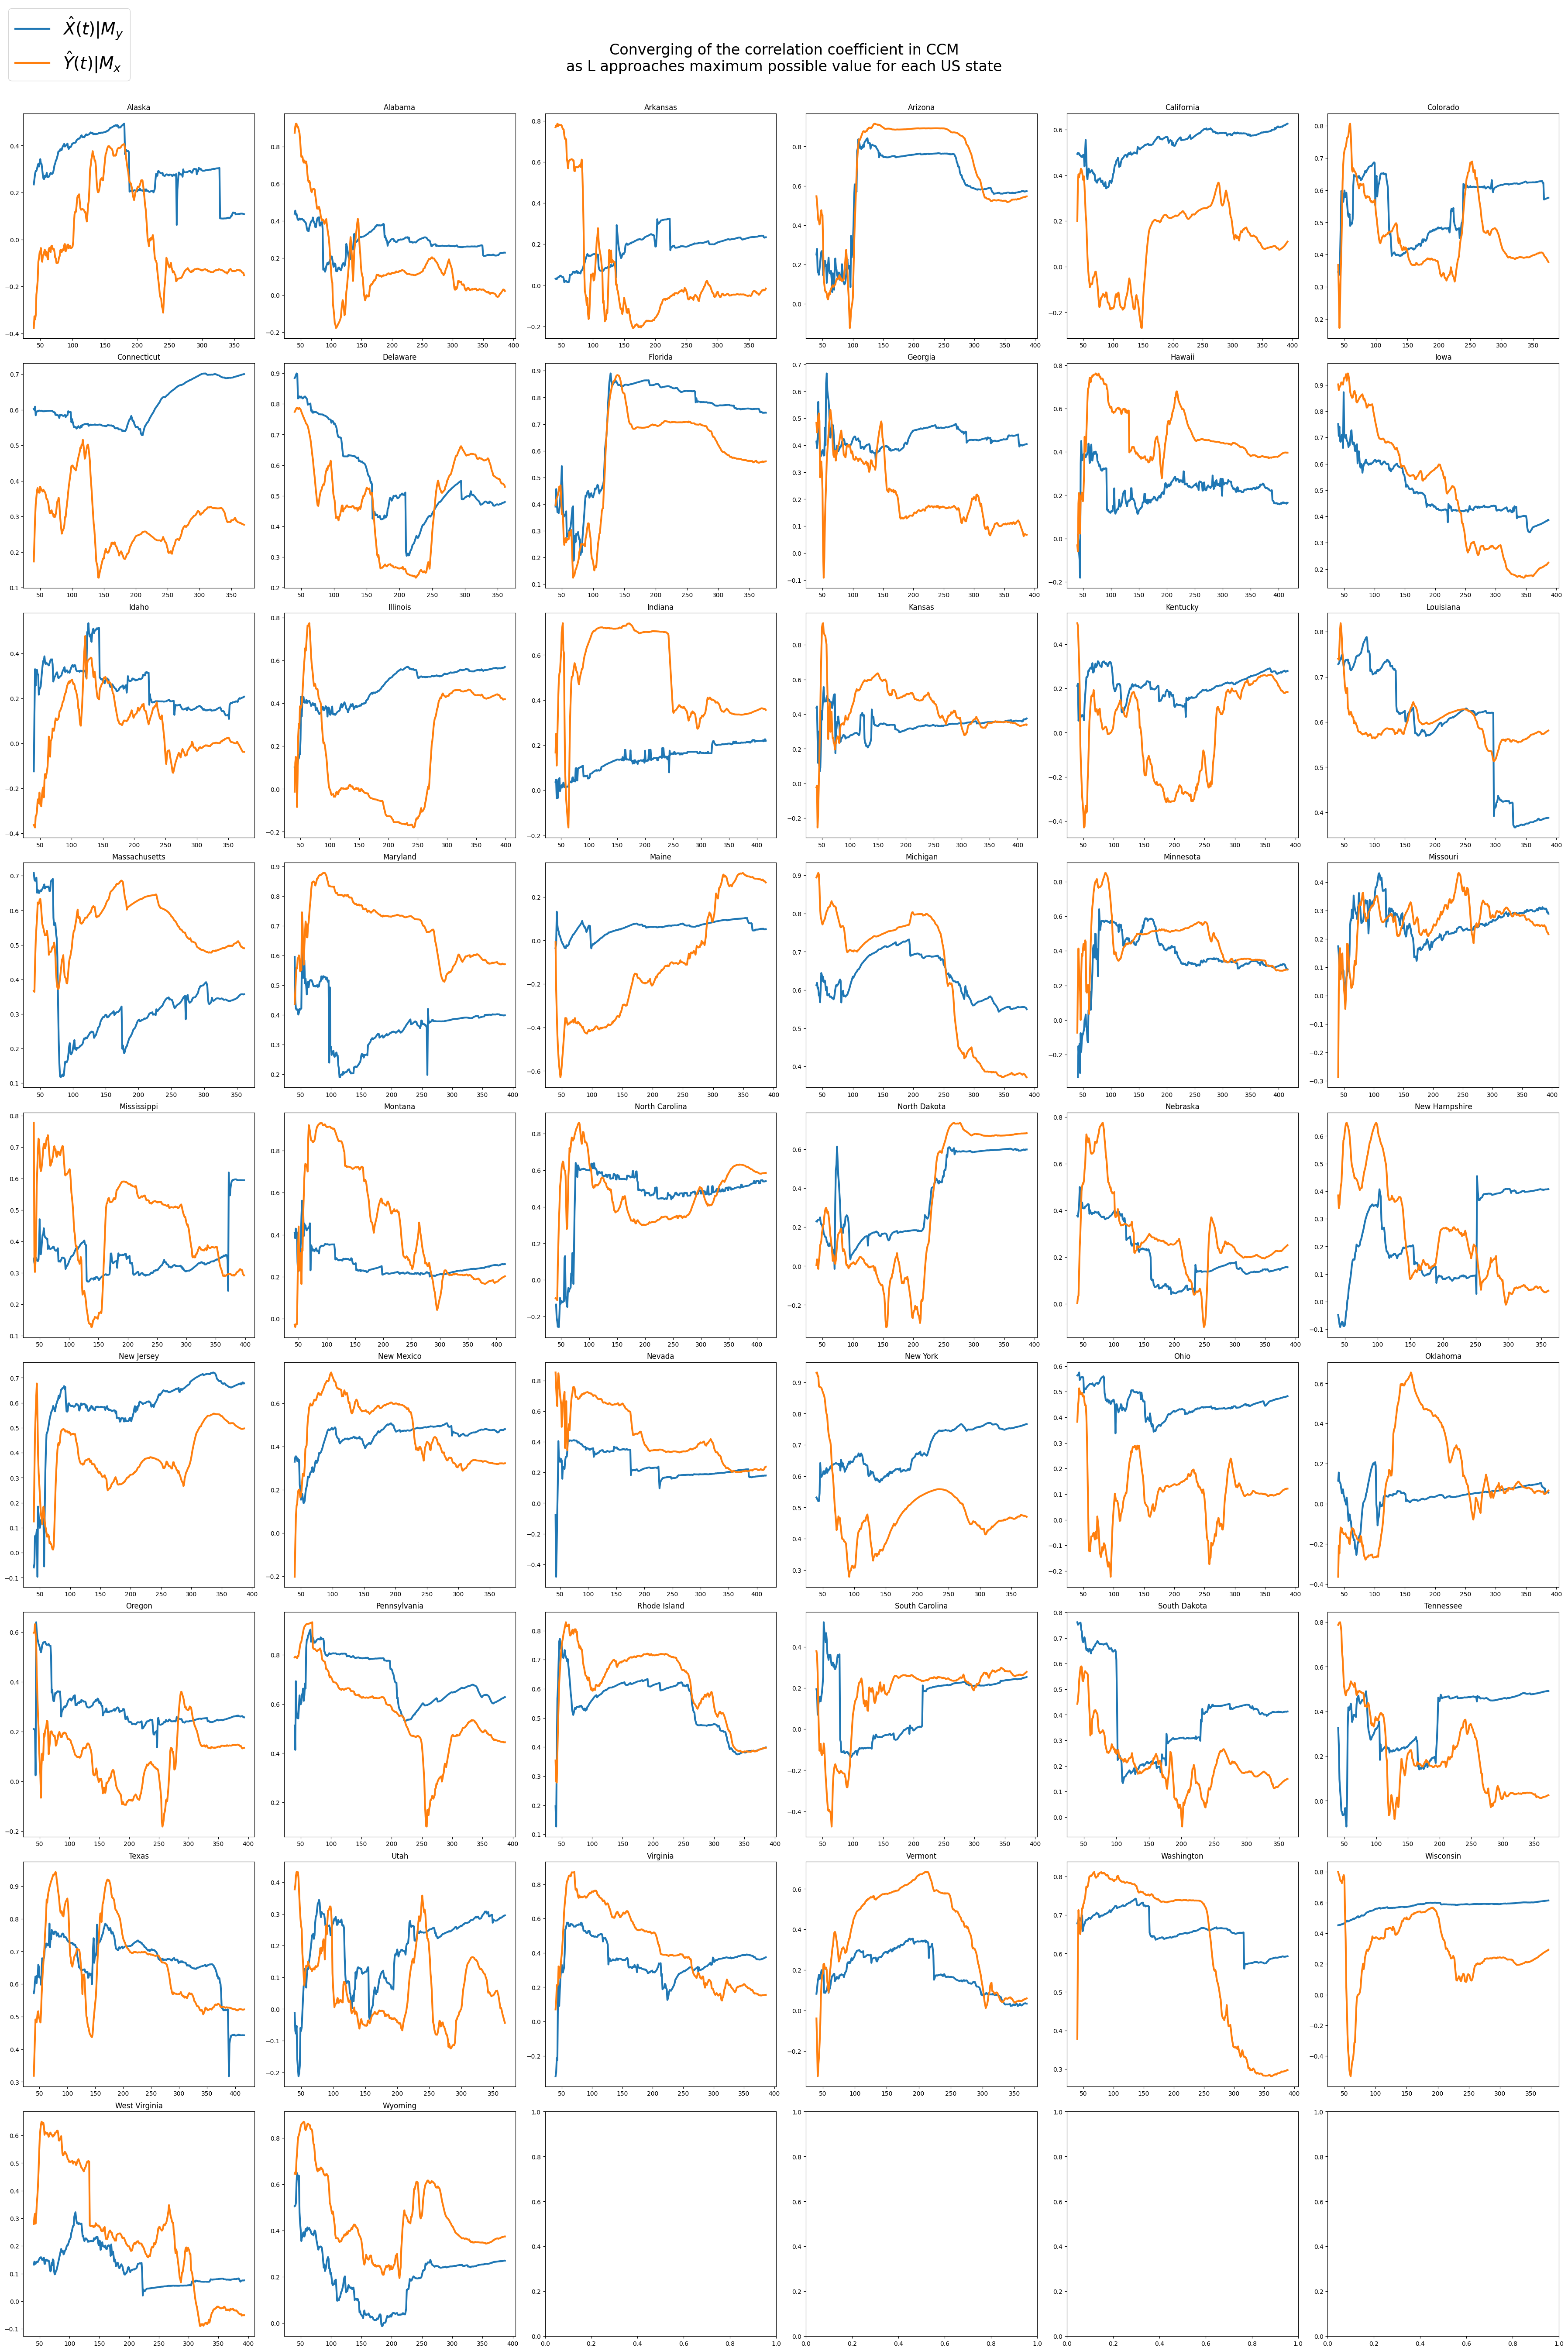

In [87]:
collage_w = 6
collage_h = 9

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(collage_h, collage_w, figsize=(36,54))

ct = 0

for subdivision in results_per_states:
    ccm0, Xhat_My, Yhat_Mx = results_per_states[subdivision]
    
    # the array of the range of L, can be different for each state
    L_range = np.arange(len(Xhat_My)) + 40
    
    p = axis[ct // collage_w, ct % collage_w]
    
    #p.figure(figsize=(5,5))
    p.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$',linewidth=3.0)
    p.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$',linewidth=3.0)
    #p.xlabel('L', size=12)
    #p.ylabel('correl', size=12)
    #p.legend(prop={'size': 12})
    p.set_title(us_states[subdivision])
    
    ct += 1

handles, labels = axis[0, 0].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper left', prop={'size': 28})
#figure.legend(prop={'size': 12})

figure.tight_layout(pad=1.0)

figure.subplots_adjust(top=0.95)
figure.suptitle('Converging of the correlation coefficient in CCM\nas L approaches maximum possible value for each US state', fontsize=24)

plt.savefig('us_collage_5a.png')

In [83]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

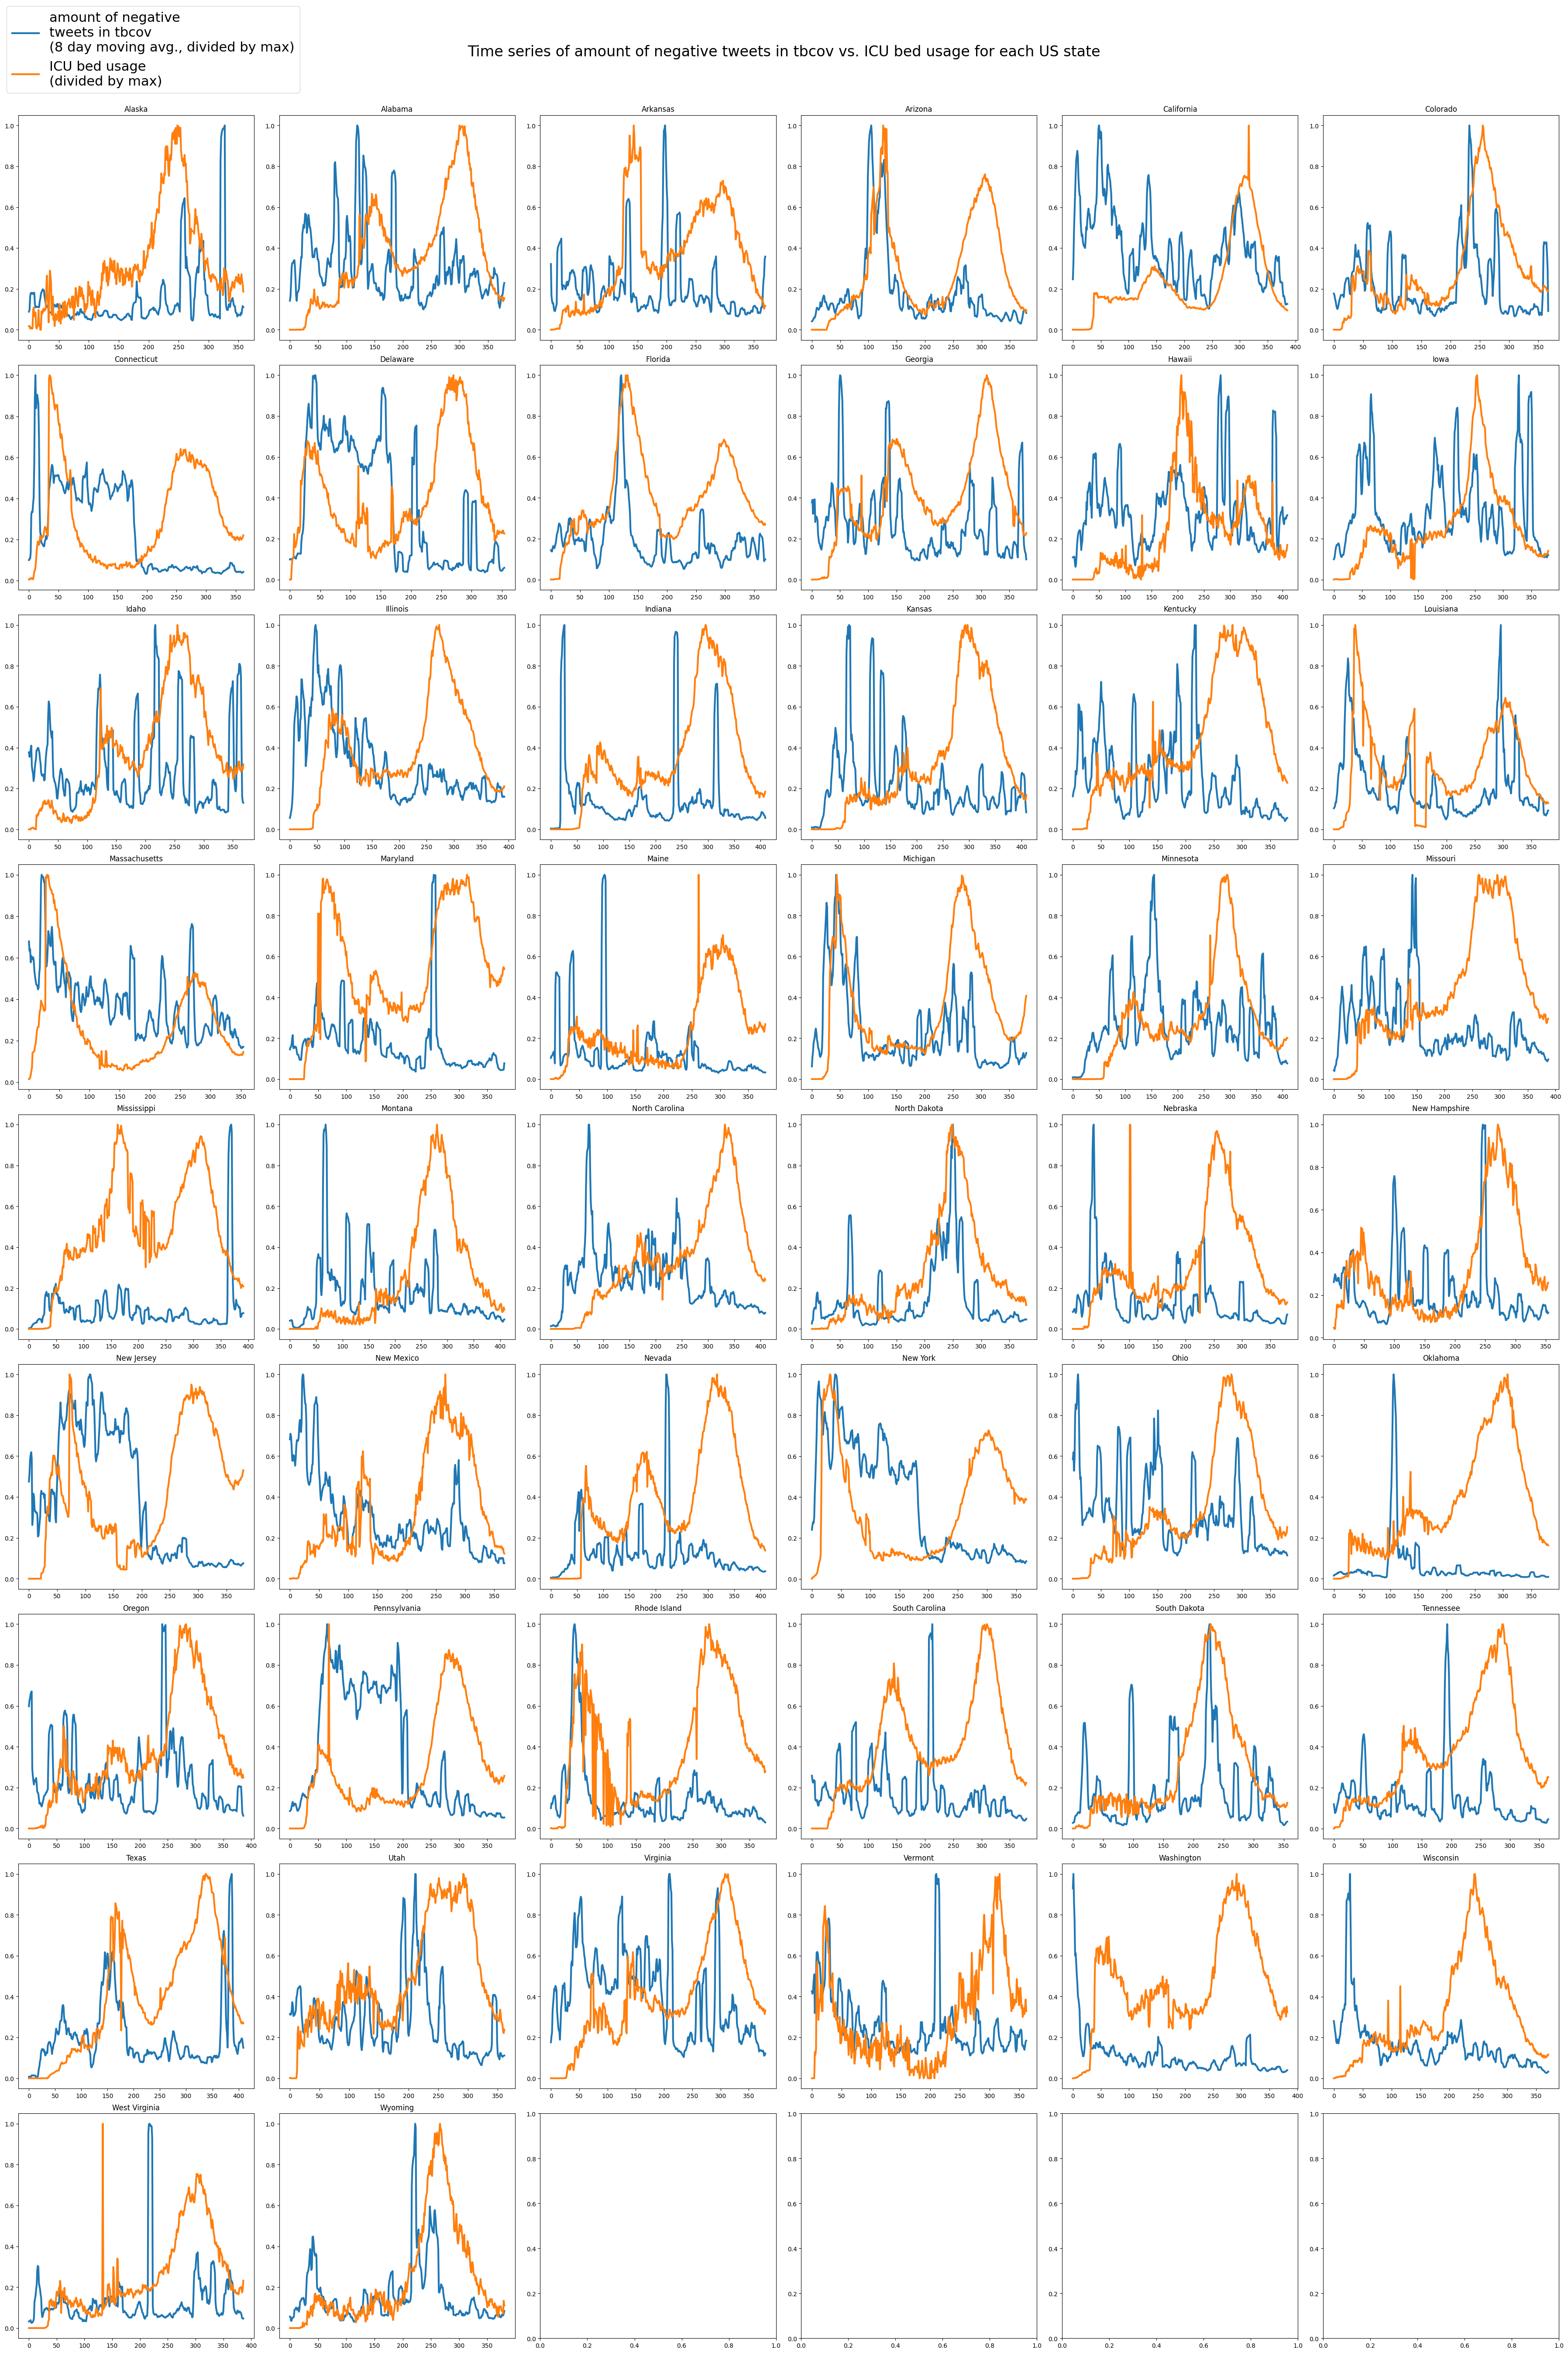

In [88]:
collage_w = 6
collage_h = 9

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(collage_h, collage_w, figsize=(36,54))

ct = 0

for subdivision in results_per_states:
    df_merged = get_state_dataseries_merged(df_us_tweets, df_us_shortage, subdivision, start_date, end_date)
    
    if df_merged is None:
        print('no data for: ', subdivision)
        continue
    
    # extract the X and Y
    X = df_merged['neg'].to_numpy()
    Y = df_merged['inpatient_beds_used_covid'].to_numpy()
    has_nan = np.isnan(Y)
    if has_nan.any():
        not_nan = np.logical_not(has_nan)
        X = X[not_nan]
        Y = Y[not_nan]
    
    X = moving_average(X, n=8)
    Y = (Y / np.amax(Y))[:len(X)]
    X = (X / np.amax(X))
    
    # the array of the range of L, can be different for each state
    day_range = np.arange(len(X))
    
    p = axis[ct // collage_w, ct % collage_w]
    
    #p.figure(figsize=(5,5))
    p.plot(day_range, X, label='amount of negative\ntweets in tbcov\n(8 day moving avg., divided by max)',linewidth=3.0)
    p.plot(day_range, Y, label='ICU bed usage\n(divided by max)',linewidth=3.0)
    #p.xlabel('L', size=12)
    #p.ylabel('correl', size=12)
    #p.legend(prop={'size': 12})
    p.set_title(us_states[subdivision])
    
    ct += 1

handles, labels = axis[0, 0].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper left', prop={'size': 22})
#figure.legend(prop={'size': 12})

figure.tight_layout(pad=1.0)

figure.subplots_adjust(top=0.95)
figure.suptitle('Time series of amount of negative tweets in tbcov vs. ICU bed usage for each US state', fontsize=24)

plt.savefig('us_collage_time_4a.png')

In [30]:
# inputs
tau = 1 # time lag
E = 8 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

# if we wish to check if X causes Y
ccm1 = ccm(X, Y, tau, E, L)

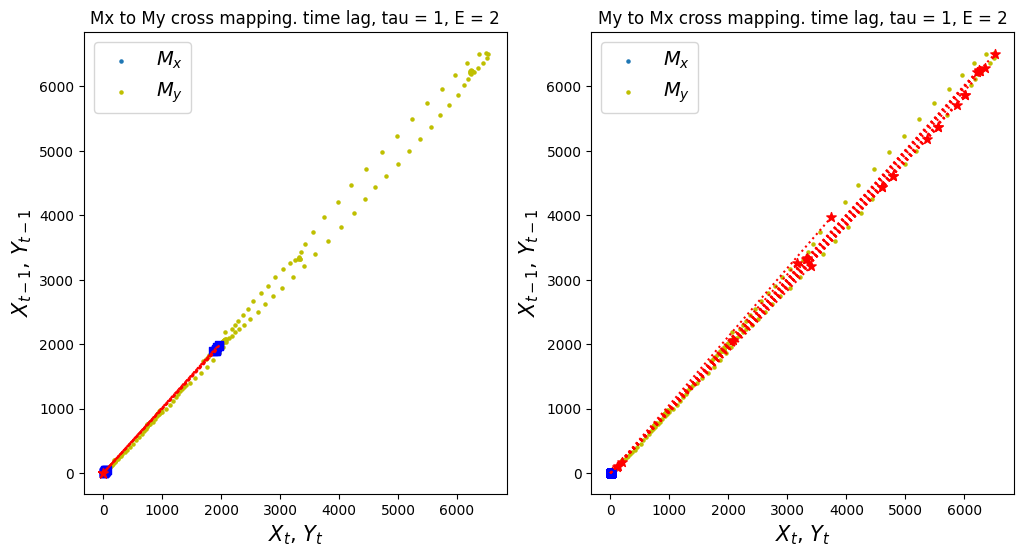

In [31]:
# visualize sample cross mapping
ccm1.visualize_cross_mapping()

In [32]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm1.causality()
corr_, p

(0.46705977941775306, 7.294551011906903e-14)

In [33]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm1.plot_ccm_correls()

IndexError: index 0 is out of bounds for axis 0 with size 0

X->Y r 0.47 p value 0.0
Y->X r 0.71 p value 0.0


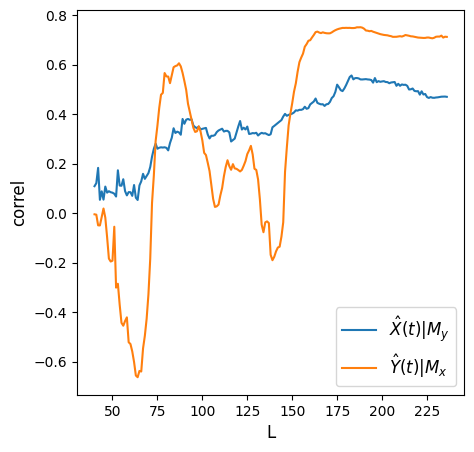

In [35]:
# checking convergence
# Looking at "convergence"
L_range = range(40, len(X), 1) # L values to test
tau = 1
E = 8

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})